In [31]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel
from uncertainties import unumpy as up
from uncertainties import ufloat
from uncertainties import wrap
from pathlib import Path

In [32]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)

In [33]:
def FWHM(s_p,g_p):
    s = ufloat(s_p.value,s_p.stderr)
    g = ufloat(g_p.value,g_p.stderr)
    fg=s*(8*up.log(2))**0.5
    fl=2*g
    return 0.5346*fl+((fg)**2+(0.2166*fl**2))**0.5

def uvoigt1(out_voigt):
    x_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x = ufloat(x_p.value,x_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    uv=wrap(voigt1)
    return uv(x,s1,g1,o1,scale1)

def uvoigt2(out_voigt):
    x1_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x2_p,s2_p,g2_p,o2_p,scale2_p=out_voigt.result.params['o2'],out_voigt.result.params['s2'],out_voigt.result.params['g2'],out_voigt.result.params['o2'],out_voigt.result.params['scale2']
    x1 = ufloat(x1_p.value,x1_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    x2 = ufloat(x2_p.value,x2_p.stderr)
    s2 = ufloat(s2_p.value,s2_p.stderr)
    g2 = ufloat(g2_p.value,g2_p.stderr)
    o2 = ufloat(o2_p.value,o2_p.stderr)
    scale2 = ufloat(scale2_p.value,scale2_p.stderr)


    uv=wrap(voigt2)

    p1 = uv(x1,s1,s2,g1,g2,o1,o2,scale1,scale2)
    p2 = uv(x2,s1,s2,g1,g2,o1,o2,scale1,scale2)
    return p1,p2

def uvoigt(out_voigt):
    try:
        return uvoigt2(out_voigt)
    except:
        return uvoigt1(out_voigt)

In [34]:
res = Path("results_40_40_mit/voigt_fits_40_40_mit.txt")
res.touch()
nf = open(res,"w")
nf.write("Amplitude1\tAmplitude2\tmu1\tmu2\tsigma1\tsigma2\tgamma1\tgamma2\tFWHM1\tFWHM2\tHeight1\tHeight2\tredchi\n")

def bwrite(fr,fwhm1,height1):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.redchi)+"\n"
                )
        

def awrite(fr,fwhm1,height1,fwhm2,height2):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                str(fr.params['scale2'].value)+"\t"+str(fr.params['scale2'].stderr)+"\t"+                
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                str(fr.params['o2'].value)+"\t"+str(fr.params['o2'].stderr)+"\t"+                
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                str(fr.params['s2'].value)+"\t"+str(fr.params['s2'].stderr)+"\t"+                
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                str(fr.params['g2'].value)+"\t"+str(fr.params['g2'].stderr)+"\t"+                
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                str(fwhm2[0])+"\t"+str(fwhm2[1])+"\t"+                
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                str(height2[0])+"\t"+str(height2[1])+"\t"+                
                str(fr.redchi)+"\n"
                )
       

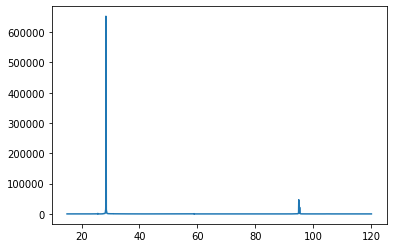

In [35]:
path =  'Data/Si_111_40_40_Ni.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])
plt.plot(data[0],data[1])

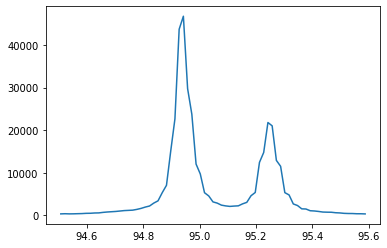

In [36]:
x=[[],[]]
for i in range(len(data[1])):
    if 94.5<data[0,i]<95.6:
        x[0].append(data[0,i])
        x[1].append(data[1,i])
plt.plot(x[0],x[1])

In [37]:
for i in range(len(data[0])):
    if data[0,i]>=95.6:
        print(i)
        break

5373


In [38]:
#modell erstellen b1 = [25.4,25.8]->[693,720]  
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.009,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["o1"].set(value=25.7,min=25.5,max=25.8)
pars_voigt["scale1"].set(100)

#Fitten
out_voigt = model_voigt.fit(data[1,693:720],x=data[0,693:720],params=pars_voigt,weights=1/data[2,693:720],nan_policy='propagate')
b1f=out_voigt.fit_report()
b1p=np.array([np.arange(25.4,25.8,0.001),out_voigt.eval(x=np.arange(25.4,25.8,0.001))])


h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)


In [39]:
#modell erstellen a1 = [28.2,28.7]->[880,913]    
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.004,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=28.4,min=28,max=29)
pars_voigt["o2"].set(value=28.5,min=28,max=29)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,880:913],x=data[0,880:913],params=pars_voigt,weights=1/data[2,880:913],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(28.2,28.7,0.001),out_voigt.eval(x=np.arange(28.2,28.7,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)



In [40]:
#modell erstellen    b2 = [52.55,52.8]->[2503,2520]
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0084,min=0,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
pars_voigt["o1"].set(value=52.677,min=52.6,max=52.8)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,2503:2520],x=data[0,2503:2520],weights=1/data[2,2503:2520],params=pars_voigt,nan_policy='propagate')
b2f=out_voigt.fit_report()
b2p=np.array([np.arange(52.55,52.8,0.001),out_voigt.eval(x=np.arange(52.55,52.8,0.001))])


h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)



In [41]:
#modell erstellen a2 = [58.7,59.1]->[2913,2940]     
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.01,max=1)
pars_voigt["g2"].set(value=0.00147,min=0,max=1)
pars_voigt["o1"].set(value=58.8,min=58.7,max=58.85)
pars_voigt["o2"].set(value=58.98,min=58.9,max=59)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,2913:2940],x=data[0,2913:2940],params=pars_voigt,weights=1/data[2,2913:2940],nan_policy='propagate')
a2f=out_voigt.fit_report()
a2p=np.array([np.arange(58.7,59.1,0.001),out_voigt.eval(x=np.arange(58.7,59.1,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)


In [42]:
#modell erstellen    b3 = [83.2,83.8]->[4547,4587]
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.1,min=0.009,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
pars_voigt["o1"].set(value=83.5,min=82.5,max=84.5)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,4547:4587],x=data[0,4547:4587],weights=1/data[2,4547:4587],params=pars_voigt,nan_policy='propagate')
b3f=out_voigt.fit_report()
b3p=np.array([np.arange(83.2,83.8,0.001),out_voigt.eval(x=np.arange(83.2,83.8,0.001))])


h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)



In [43]:
#modell erstellen a3 = [94.5,95.6]->[5300,5373]       
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.009,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.009,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=94.8,min=94,max=96)
pars_voigt["o2"].set(value=95.25,min=94,max=96)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,5300:5373],x=data[0,5300:5373],params=pars_voigt,weights=1/data[2,5300:5373],nan_policy='propagate')
a3f=out_voigt.fit_report()
a3p=np.array([np.arange(94.5,95.6,0.001),out_voigt.eval(x=np.arange(94.5,95.6,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)


nf.close()

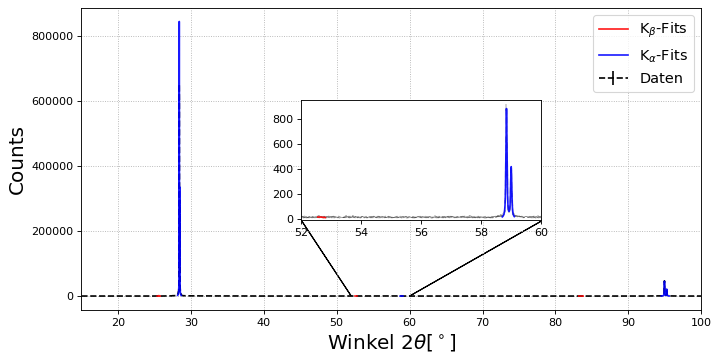

In [44]:
fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')
plt.plot(b1p[0],b1p[1],zorder=10,label='K'r'$_\beta$''-Fits',color='r',alpha=0.9)
plt.plot(a1p[0],a1p[1],zorder=10,label='K'r'$_\alpha$''-Fits',color='b',alpha=0.9)
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.plot(b3p[0],b3p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a3p[0],a3p[1],zorder=10,color='b',alpha=0.9)

plt.legend(fontsize=13)
plt.grid(axis='both',linestyle=':')
plt.xlim(15,100)
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.arrow(45.25,230000,6.75,-230000)
plt.arrow(78,230000,-18,-230000)


# this is an inset axes over the main axes
a = plt.axes([.4, .35, .3, .3])
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',alpha=0.2)
plt.ylim(-10,950)
plt.xlim(52,60)
plt.savefig('plots_40_40_mit/spek_40_40_mit.pdf')

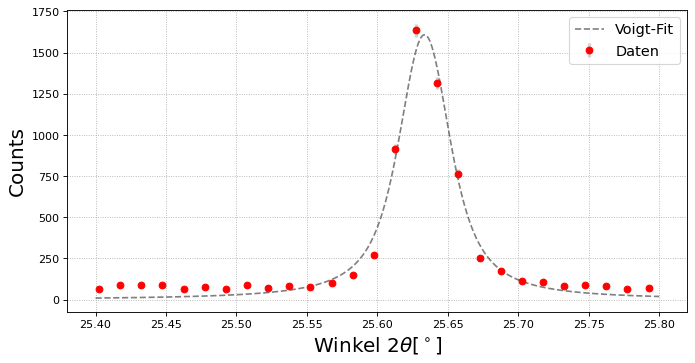

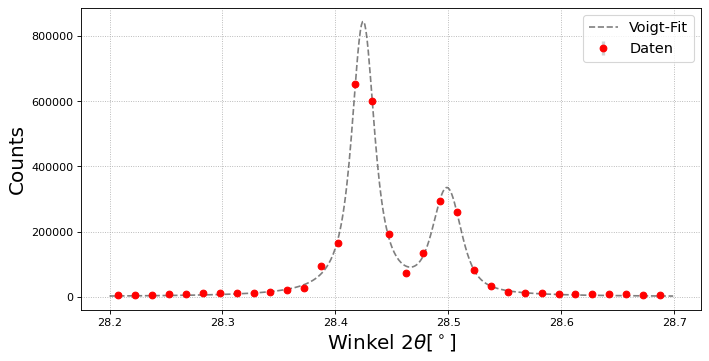

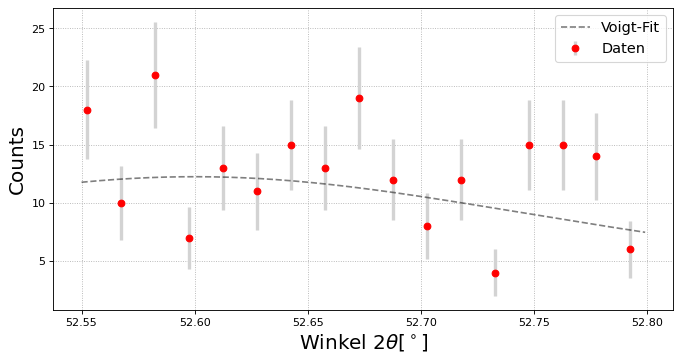

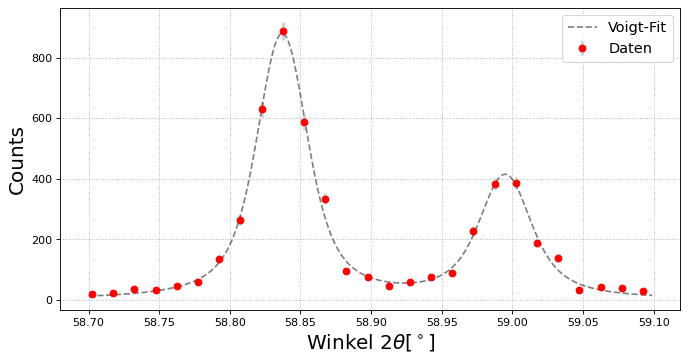

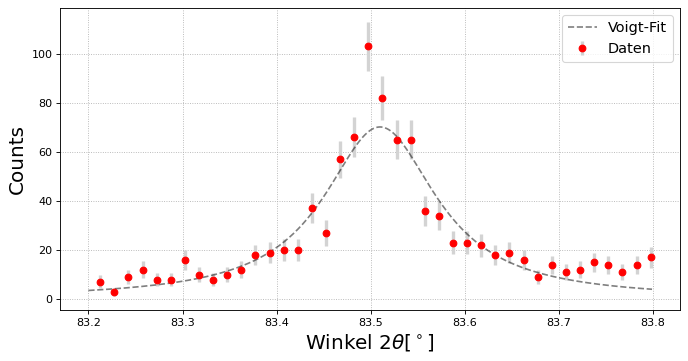

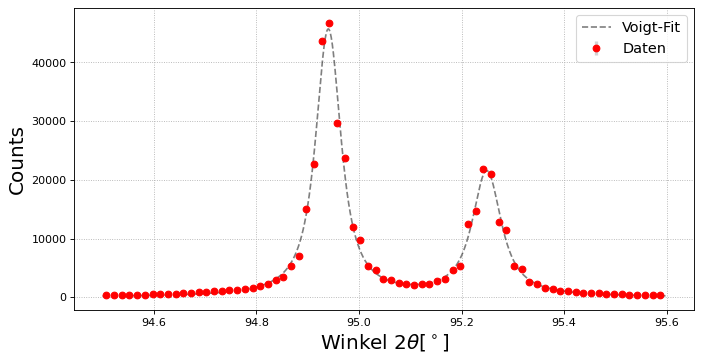

In [45]:
#plt.style.use('fivethirtyeight')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,693:720],data[1,693:720],yerr=data[2,693:720],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b1p[0],b1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/b1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,880:913],data[1,880:913],yerr=data[2,880:913],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/a1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,2503:2520],data[1,2503:2520],yerr=data[2,2503:2520],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b2p[0],b2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/b2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,2913:2940],data[1,2913:2940],yerr=data[2,2913:2940],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a2p[0],a2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/a2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,4547:4587],data[1,4547:4587],yerr=data[2,4547:4587],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b3p[0],b3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/b3.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,5300:5373],data[1,5300:5373],yerr=data[2,5300:5373],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a3p[0],a3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('plots_40_40_mit/a3.pdf')

In [46]:
print('b1#######################################')
print(b1f)
print('a1#######################################')
print(a1f)
print('b2#######################################')
print(b2f)
print('a2#######################################')
print(a2f)
print('b3#######################################')
print(b3f)
print('a3#######################################')
print(a3f)

b1#######################################
[[Model]]
    Model(voigt1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 27
    # variables        = 4
    chi-square         = 647.628458
    reduced chi-square = 28.1577591
    Akaike info crit   = 93.7919681
    Bayesian info crit = 98.9753155
[[Variables]]
    s1:      0.00900000 +/- 0.00105796 (11.76%) (init = 0.0137)
    g1:      0.01658647 +/- 0.00336154 (20.27%) (init = 0.0137)
    o1:      25.6334887 +/- 0.00176031 (0.01%) (init = 25.7)
    scale1:  101.638916 +/- 6.95483747 (6.84%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(s1, g1)     = 0.825
    C(g1, scale1) = 0.244
    C(s1, scale1) = 0.230
a1#######################################
[[Model]]
    Model(voigt2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 136
    # data points      = 33
    # variables        = 8
    chi-square         = 47029.4222
    reduced c